# Genre Tags Analysis using Sci-kit Learn
This notebook will be employing sklearn models to try to predict one of the genre tags corresponding to each track.

## Preprocessing and Basic Feature Engineering
Here, we will be removing unnecessary columns from the dataframe and preparing the data to be used with sklearn models.

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataframe_path = './dataframe_with_vector_compressed.pkl'
df = pd.read_pickle(dataframe_path, compression='zip')

In [3]:
df.head()

,track_id,artist_name,duration,loudness,tempo,title,year,lyrics,tags,lyrics_vector
0,TRMMMKI128F931D80D,Lena Philipsson,262.26893,-3.925,122.332,006,1998,"1:23,2:5,3:13,4:10,5:4,6:9,7:1,8:4,9:4,10:1,11...","[[swedish, 100], [pop, 100]]","[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ..."
1,TRMMMUT128F42646E8,Shawn Colvin,216.47628,-14.379,99.214,(Looking For) The Heart Of Saturday,1994,"2:36,3:25,4:2,5:8,6:2,7:1,8:6,10:8,12:5,13:19,...","[[cover, 100]]","[0, 0, 36, 25, 2, 8, 2, 1, 6, 0, 8, 0, 5, 19, ..."
2,TRMMMQY128F92F0EA3,Dying Fetus,196.02240,-6.366,189.346,Ethos of Coercion,2009,"2:10,3:1,4:2,5:1,9:1,10:1,13:9,14:2,18:1,21:1,...","[[Technical Death Metal, 100], [Brutal Death M...","[0, 0, 10, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 9, 2,..."
3,TRMMMTK128F424EF7C,Emery,217.57342,-4.867,88.423,Rock-N-Rule,2007,"1:20,2:8,3:15,4:4,5:5,6:6,7:2,8:9,9:12,10:2,11...","[[post-hardcore, 100], [emo, 75], [rock, 50], ...","[0, 20, 8, 15, 4, 5, 6, 2, 9, 12, 2, 2, 7, 1, ..."
4,TRMMMQV12903CA201E,Rev. Timothy Wright,353.77587,-7.569,167.850,I Made It Over,0,"1:24,2:1,3:15,4:4,5:4,7:4,8:12,11:2,35:4,40:2,...","[[THE WRIGHT WAY, 100]]","[0, 24, 1, 15, 4, 4, 0, 4, 12, 0, 0, 2, 0, 0, ..."


As you can see in the output above, there are many columns that we do not need. Those will be dropped.

In [4]:
df_genre = df.drop(['artist_name', 'duration', 'loudness', 'tempo', 'title', 'year', 'lyrics'], axis=1)
df_genre.head()

,track_id,tags,lyrics_vector
0,TRMMMKI128F931D80D,"[[swedish, 100], [pop, 100]]","[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ..."
1,TRMMMUT128F42646E8,"[[cover, 100]]","[0, 0, 36, 25, 2, 8, 2, 1, 6, 0, 8, 0, 5, 19, ..."
2,TRMMMQY128F92F0EA3,"[[Technical Death Metal, 100], [Brutal Death M...","[0, 0, 10, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 9, 2,..."
3,TRMMMTK128F424EF7C,"[[post-hardcore, 100], [emo, 75], [rock, 50], ...","[0, 20, 8, 15, 4, 5, 6, 2, 9, 12, 2, 2, 7, 1, ..."
4,TRMMMQV12903CA201E,"[[THE WRIGHT WAY, 100]]","[0, 24, 1, 15, 4, 4, 0, 4, 12, 0, 0, 2, 0, 0, ..."


This is much closer to the information we need to provide the models. However, the tags format still needs some work. 

### Tags
Since the dataset originally provided approximately 20,000 tags, we will be reducing this number by determining which tags occur most frequently. Note: we are currently ignoring the confidence values associated with each tag for this part of the process. Later on, we will only use tags above a certain confidence level.

In [5]:
all_tags = df_genre['tags'].to_list()
flattened_tags_list = []
for item in all_tags:
    if isinstance(item, list):
        flattened_tags_list.extend(item) # copy all elements within item (list) into the flattened list
    elif item is not None:
        flattened_tags_list.append(item) # copy the single item (tag) into the flattened list

print(len(flattened_tags_list))
print(flattened_tags_list[:5])

3930850
[['swedish', '100'], ['pop', '100'], ['cover', '100'], ['Technical Death Metal', '100'], ['Brutal Death Metal', '85']]


Now that we have all the tags in the form of (tag, weight) tuples, we can remove the confidence weights.

In [6]:
tags_without_weights = [str(tag).lower() for (tag, weight) in flattened_tags_list]

print(len(tags_without_weights))
print(tags_without_weights[:5])

3930850
['swedish', 'pop', 'cover', 'technical death metal', 'brutal death metal']


Now that we have the list of all tags, we need to find how frequently each one occurs. We will keep this as a dataframe.

In [7]:
unique_tags, unique_counts = np.unique(tags_without_weights, return_counts=True)
df_tag_count = pd.DataFrame(unique_tags, columns=['tag'])
df_tag_count['count'] = unique_counts

In [8]:
df_tag_count.head(15)

,tag,count
0,,6
1,#1,25
2,'00s,107
3,'50s,2
4,'60,1
5,'60s,11
6,'70s,10
7,'77 punk,1
8,'80s,35
9,'90,1


To get a sense of the tag frequencies, we can print out the how many tags occur X amount of times.

In [9]:
def tagsAboveThreshold(df, threshold):
    return df[df['count'] >= threshold]

In [10]:
thresholds = [25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7500, 10000]
df_list = [df_tag_count] * len(thresholds)

result = map(tagsAboveThreshold, df_list, thresholds)
results = [r for r in result] # consumes the "map" so need to do this first
counts = [r.shape[0] for r in results]

pairs = [(t, c) for (t, c) in zip(thresholds, counts)]

for p in pairs:
    print("Threshold %d, Count %d" % p)

Threshold 25, Count 17579
Threshold 50, Count 8696
Threshold 75, Count 5593
Threshold 100, Count 4081
Threshold 150, Count 2665
Threshold 200, Count 1966
Threshold 250, Count 1544
Threshold 300, Count 1273
Threshold 400, Count 946
Threshold 500, Count 752
Threshold 750, Count 483
Threshold 1000, Count 365
Threshold 1500, Count 247
Threshold 2000, Count 188
Threshold 2500, Count 158
Threshold 3000, Count 136
Threshold 4000, Count 95
Threshold 5000, Count 74
Threshold 7500, Count 39
Threshold 10000, Count 27


In [11]:
from pprint import pprint # pretty print the long list
chosen_thresh = 10000
thresh_idx = thresholds.index(chosen_thresh)
pprint(results[thresh_idx])

                      tag  count
691                   00s  16566
5475                  80s  11907
6118                  90s  12728
16346         alternative  32021
16623    alternative rock  18897
18059            american  11834
26860             awesome  13709
32753           beautiful  15179
47415             british  11490
62033        classic rock  12748
73139               dance  10401
93421          electronic  11752
105216          favorites  21430
107529   female vocalists  21534
111605               folk  11831
137554          hard rock  11808
157068              indie  26270
157597         indie rock  14604
191347               love  18038
198200     male vocalists  13902
204081             mellow  12778
205929              metal  17744
251912                pop  35672
259301               punk  12518
272476               rock  55991
283608          seen live  12697
290659  singer-songwriter  16292


Above is the list of tags and their asoociated counts for the chosen threshold. As you can see, some of the tags are very subjective and are not necesarrily considered genres. From this list, we can manually choose which tags we deem most appropriate for the purposes of this project exploration.

In [12]:
# manually chosen
chosen_tags = ['alternative', 'classic rock', 'dance', 'electronic', 'folk', 'hard rock', 'indie', 'indie rock', 'metal', 'pop', 'punk']

Now we want to get only the tracks that include one of these chosen tags. First we have to filter out the tracks with no tags, and only keep the tags above a certain confidence threshold.

In [13]:
def getTagsList(tagWeightList, weightThreshold=0):
    if tagWeightList is None or len(tagWeightList) == 0:
        return []
    else:
        result = []
        for item in tagWeightList:
            if int(item[1]) >= weightThreshold:
                result.append(item[0]) # just the tag, without the score next to it
        return result

In [14]:
df_genre['tags_list'] = df_genre['tags'].apply(getTagsList, weightThreshold=50)
df_genre.head(10)

,track_id,tags,lyrics_vector,tags_list
0,TRMMMKI128F931D80D,"[[swedish, 100], [pop, 100]]","[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...","[swedish, pop]"
1,TRMMMUT128F42646E8,"[[cover, 100]]","[0, 0, 36, 25, 2, 8, 2, 1, 6, 0, 8, 0, 5, 19, ...",[cover]
2,TRMMMQY128F92F0EA3,"[[Technical Death Metal, 100], [Brutal Death M...","[0, 0, 10, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 9, 2,...","[Technical Death Metal, Brutal Death Metal]"
3,TRMMMTK128F424EF7C,"[[post-hardcore, 100], [emo, 75], [rock, 50], ...","[0, 20, 8, 15, 4, 5, 6, 2, 9, 12, 2, 2, 7, 1, ...","[post-hardcore, emo, rock, emocore]"
4,TRMMMQV12903CA201E,"[[THE WRIGHT WAY, 100]]","[0, 24, 1, 15, 4, 4, 0, 4, 12, 0, 0, 2, 0, 0, ...",[THE WRIGHT WAY]
5,TRMMMNO128F93539AA,"[[singer-songwriter, 100], [rock, 66], [jazz, ...","[0, 30, 15, 4, 6, 15, 5, 3, 13, 11, 6, 5, 2, 2...","[singer-songwriter, rock]"
6,TRMMMPJ128F9306985,"[[cristian castro, 100], [azul, 100], [Roma, 5...","[0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...","[cristian castro, azul, Roma, favoritas, Roman..."
7,TRMMMRZ128F4265EB4,"[[classic rock, 100], [rock, 83], [hard rock, ...","[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...","[classic rock, rock, hard rock]"
8,TRMMMKQ128F92EBCB5,"[[thrash metal, 100], [metal, 32], [thrash, 23...","[0, 0, 12, 2, 3, 4, 0, 0, 0, 0, 2, 0, 1, 9, 0,...",[thrash metal]
9,TRMMMBU128F9305AC3,"[[reggae, 100], [rocksteady, 75], [EARLY REGGA...","[0, 6, 4, 4, 2, 7, 0, 0, 0, 0, 1, 5, 0, 1, 0, ...","[reggae, rocksteady]"


Now we want to see if the tags list from the new column contains one of the chosen tags.

In [15]:
def trackIncludesTags(track_tags, wanted_tags):
    for tag in track_tags:
        if tag in wanted_tags:
            return True
    return False # none of the track tags are in wanted_tags

In [16]:
df_genre['includesTag'] = df_genre['tags_list'].apply(trackIncludesTags, wanted_tags=set(chosen_tags))
df_genre.head(10)

,track_id,tags,lyrics_vector,tags_list,includesTag
0,TRMMMKI128F931D80D,"[[swedish, 100], [pop, 100]]","[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...","[swedish, pop]",True
1,TRMMMUT128F42646E8,"[[cover, 100]]","[0, 0, 36, 25, 2, 8, 2, 1, 6, 0, 8, 0, 5, 19, ...",[cover],False
2,TRMMMQY128F92F0EA3,"[[Technical Death Metal, 100], [Brutal Death M...","[0, 0, 10, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 9, 2,...","[Technical Death Metal, Brutal Death Metal]",False
3,TRMMMTK128F424EF7C,"[[post-hardcore, 100], [emo, 75], [rock, 50], ...","[0, 20, 8, 15, 4, 5, 6, 2, 9, 12, 2, 2, 7, 1, ...","[post-hardcore, emo, rock, emocore]",False
4,TRMMMQV12903CA201E,"[[THE WRIGHT WAY, 100]]","[0, 24, 1, 15, 4, 4, 0, 4, 12, 0, 0, 2, 0, 0, ...",[THE WRIGHT WAY],False
5,TRMMMNO128F93539AA,"[[singer-songwriter, 100], [rock, 66], [jazz, ...","[0, 30, 15, 4, 6, 15, 5, 3, 13, 11, 6, 5, 2, 2...","[singer-songwriter, rock]",False
6,TRMMMPJ128F9306985,"[[cristian castro, 100], [azul, 100], [Roma, 5...","[0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...","[cristian castro, azul, Roma, favoritas, Roman...",False
7,TRMMMRZ128F4265EB4,"[[classic rock, 100], [rock, 83], [hard rock, ...","[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...","[classic rock, rock, hard rock]",True
8,TRMMMKQ128F92EBCB5,"[[thrash metal, 100], [metal, 32], [thrash, 23...","[0, 0, 12, 2, 3, 4, 0, 0, 0, 0, 2, 0, 1, 9, 0,...",[thrash metal],False
9,TRMMMBU128F9305AC3,"[[reggae, 100], [rocksteady, 75], [EARLY REGGA...","[0, 6, 4, 4, 2, 7, 0, 0, 0, 0, 1, 5, 0, 1, 0, ...","[reggae, rocksteady]",False


In [17]:
indexNames = df_genre[ df_genre['includesTag'] == False ].index
 
# Delete these row indexes from dataFrame
df_songs_wanted_tags = df_genre.drop(indexNames)
df_songs_wanted_tags.head(10)

,track_id,tags,lyrics_vector,tags_list,includesTag
0,TRMMMKI128F931D80D,"[[swedish, 100], [pop, 100]]","[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...","[swedish, pop]",True
7,TRMMMRZ128F4265EB4,"[[classic rock, 100], [rock, 83], [hard rock, ...","[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...","[classic rock, rock, hard rock]",True
14,TRMMWJS12903CBB7F5,"[[rock, 100], [classic rock, 75], [hard rock, ...","[0, 8, 6, 2, 7, 3, 2, 1, 4, 0, 4, 4, 1, 0, 0, ...","[rock, classic rock, hard rock]",True
18,TRMMWQU12903CF447F,"[[Avant-garde Metal, 100], [metal, 50], [male ...","[0, 0, 14, 8, 4, 7, 9, 2, 2, 1, 1, 0, 1, 7, 6,...","[Avant-garde Metal, metal]",True
20,TRMMWAO128F42A53EB,"[[pop, 100], [dammi solo un minuto, 100], [Itl...","[0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...","[pop, dammi solo un minuto, Itlian song]",True
27,TRMMGTX128F92FB4D9,"[[latin, 100], [pop, 100]]","[0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, ...","[latin, pop]",True
32,TRMMGGU128F14A93DD,"[[pop, 100], [rock, 33], [finnish, 33], [00s, ...","[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, ...",[pop],True
34,TRMMHTC12903C9AF55,"[[indie, 100], [britpop, 100], [80s, 85], [roc...","[0, 3, 16, 13, 4, 4, 1, 2, 3, 4, 7, 1, 0, 0, 1...","[indie, britpop, 80s, rock, margaret thatcher,...",True
36,TRMMHDI128F42442F4,"[[indie, 100], [biffy clyro, 50], [alternative...","[0, 18, 18, 12, 2, 3, 3, 10, 10, 8, 1, 2, 3, 1...","[indie, biffy clyro, alternative rock]",True
38,TRMMHGC128F9338059,"[[punk, 100], [female vocalists, 100]]","[0, 9, 2, 2, 9, 9, 5, 5, 5, 0, 1, 1, 2, 13, 1,...","[punk, female vocalists]",True


This dataframe now only contains the tracks that have at least 1 of the chosen tags. Next we must choose which tag we want to be the singular target tag for the model to train on.

In [18]:
def getTargetTag(tags_list, wanted_tags):
    for tag in tags_list:
        if tag in wanted_tags:
            return tag
    return None # should never happen due to prior filtering

In [19]:
df_songs_wanted_tags['target_tag'] = df_songs_wanted_tags['tags_list'].apply(getTargetTag, wanted_tags=set(chosen_tags))
df_songs_wanted_tags.head(10)

,track_id,tags,lyrics_vector,tags_list,includesTag,target_tag
0,TRMMMKI128F931D80D,"[[swedish, 100], [pop, 100]]","[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...","[swedish, pop]",True,pop
7,TRMMMRZ128F4265EB4,"[[classic rock, 100], [rock, 83], [hard rock, ...","[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...","[classic rock, rock, hard rock]",True,classic rock
14,TRMMWJS12903CBB7F5,"[[rock, 100], [classic rock, 75], [hard rock, ...","[0, 8, 6, 2, 7, 3, 2, 1, 4, 0, 4, 4, 1, 0, 0, ...","[rock, classic rock, hard rock]",True,classic rock
18,TRMMWQU12903CF447F,"[[Avant-garde Metal, 100], [metal, 50], [male ...","[0, 0, 14, 8, 4, 7, 9, 2, 2, 1, 1, 0, 1, 7, 6,...","[Avant-garde Metal, metal]",True,metal
20,TRMMWAO128F42A53EB,"[[pop, 100], [dammi solo un minuto, 100], [Itl...","[0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...","[pop, dammi solo un minuto, Itlian song]",True,pop
27,TRMMGTX128F92FB4D9,"[[latin, 100], [pop, 100]]","[0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, ...","[latin, pop]",True,pop
32,TRMMGGU128F14A93DD,"[[pop, 100], [rock, 33], [finnish, 33], [00s, ...","[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, ...",[pop],True,pop
34,TRMMHTC12903C9AF55,"[[indie, 100], [britpop, 100], [80s, 85], [roc...","[0, 3, 16, 13, 4, 4, 1, 2, 3, 4, 7, 1, 0, 0, 1...","[indie, britpop, 80s, rock, margaret thatcher,...",True,indie
36,TRMMHDI128F42442F4,"[[indie, 100], [biffy clyro, 50], [alternative...","[0, 18, 18, 12, 2, 3, 3, 10, 10, 8, 1, 2, 3, 1...","[indie, biffy clyro, alternative rock]",True,indie
38,TRMMHGC128F9338059,"[[punk, 100], [female vocalists, 100]]","[0, 9, 2, 2, 9, 9, 5, 5, 5, 0, 1, 1, 2, 13, 1,...","[punk, female vocalists]",True,punk


In [20]:
# remove temp columns and clean up row numbers
df_genre_tags = df_songs_wanted_tags.drop(['tags', 'tags_list', 'includesTag'], axis=1)
df_genre_tags = df_genre_tags.reset_index(drop=True) # resets numbering of the rows
df_genre_tags.head()

,track_id,lyrics_vector,target_tag
0,TRMMMKI128F931D80D,"[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...",pop
1,TRMMMRZ128F4265EB4,"[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...",classic rock
2,TRMMWJS12903CBB7F5,"[0, 8, 6, 2, 7, 3, 2, 1, 4, 0, 4, 4, 1, 0, 0, ...",classic rock
3,TRMMWQU12903CF447F,"[0, 0, 14, 8, 4, 7, 9, 2, 2, 1, 1, 0, 1, 7, 6,...",metal
4,TRMMWAO128F42A53EB,"[0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...",pop


### Lyrics
Now that all the works with tags are done, we will focus on cleaning up the lyrics.
While they are currently fine as the vector, the vector is very sparse, with 5000 columns. On average, less than 50 of those columns have non-zero values. We will convert the vector into multiple columns that each contain an integer value representing the combines bag-of-words index and count in a single number. We will also remove the stopwords from the nltk package to remove the occurences of extrmely common words that probably do not contribute much to the genre of the song.

#### Stopwords
First we need a list of stopwords, and we want to compare those words with the lyrics.

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/surajmasand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

In [23]:
bagged_words_list = './word_list.json' # bag of words from the dataset

In [24]:
import json
word_list = []
with open(bagged_words_list, 'r') as w:
    word_list = list(json.load(w))

In [25]:
print(len(word_list)) # should be 5001 because of extra whitespace at index 0
print(word_list[:10])

5001
[' ', 'i', 'the', 'you', 'to', 'and', 'a', 'me', 'it', 'not']


Now that we have the list of words in the correct order, we can find where are the stopwords to ignore. 

In [26]:
def commonElementIndices(list1, list2):
    # returns the indices of the list2 elements if found in list1
    indices = []
    for e in list2:
        if e in list1:
            indices.append(list1.index(e))
    return set(indices)

In [27]:
stopwords_indices_in_lyrics = commonElementIndices(word_list, stopwords_list)
print(len(stopwords_indices_in_lyrics))

116


In [28]:
from stemming.porter2 import stem # same stemming used by million song dataset

In [29]:
stemmed_stopwords = [stem(s) for s in stopwords_list]
stemmed_stopwords_indices_in_lyrics = commonElementIndices(word_list, stemmed_stopwords)
combined_stopwords_indices = set(stopwords_indices_in_lyrics).union(set(stemmed_stopwords_indices_in_lyrics))
print(len(combined_stopwords_indices))

128


Now we can remove these stopwords from the bag of words. We will do this by setting the corresponding indices in the lyrics vector to 0 (so that these words are ignored and removed in later steps).

In [30]:
def removeStopwordsFromLyricsVector(lyrics, indices):
    lyrics_copy = lyrics.copy()
    for i in indices:
        lyrics_copy[i] = 0
    return lyrics_copy

In [31]:
df_genre_tags['lyrics_stopwords'] = df_genre_tags['lyrics_vector'].apply(removeStopwordsFromLyricsVector, indices=combined_stopwords_indices)
df_genre_tags.head()

,track_id,lyrics_vector,target_tag,lyrics_stopwords
0,TRMMMKI128F931D80D,"[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...",pop,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,TRMMMRZ128F4265EB4,"[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...",classic rock,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,TRMMWJS12903CBB7F5,"[0, 8, 6, 2, 7, 3, 2, 1, 4, 0, 4, 4, 1, 0, 0, ...",classic rock,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,TRMMWQU12903CF447F,"[0, 0, 14, 8, 4, 7, 9, 2, 2, 1, 1, 0, 1, 7, 6,...",metal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,TRMMWAO128F42A53EB,"[0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...",pop,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [32]:
# verify the lyrics_stopwords columns contains values other than 0
print(np.unique(df_genre_tags['lyrics_stopwords'].to_list()[:5]))

[ 0  1  2  3  4  5  6  7  8  9 10 13 14 16 22]


#### Condensing the lyrics
Now we will replace all values with the an integer representing the index and count as a single value. Then we can remove all the 0 elements while still remembering the information about the original indices for the other values.

In [33]:
def integerizeLyrics(lyrics):
    result = []
    nonzero_idx = np.nonzero(lyrics)[0] # index 0 of output tuple
    for i in nonzero_idx:
        if lyrics[i] != 0:
            result.append(i*100 + lyrics[i])
    return result

In [34]:
df_genre_tags['lyrics_condensed'] = df_genre_tags['lyrics_stopwords'].apply(integerizeLyrics)
df_genre_tags.head()

,track_id,lyrics_vector,target_tag,lyrics_stopwords,lyrics_condensed
0,TRMMMKI128F931D80D,"[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...",pop,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2701, 3901, 4104, 5703, 5801, 6101, 6603, 750..."
1,TRMMMRZ128F4265EB4,"[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...",classic rock,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2902, 3602, 4101, 4601, 4801, 5701, 5801, 610..."
2,TRMMWJS12903CBB7F5,"[0, 8, 6, 2, 7, 3, 2, 1, 4, 0, 4, 4, 1, 0, 0, ...",classic rock,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3601, 4401, 4607, 6802, 7101, 7302, 7402, 850..."
3,TRMMWQU12903CF447F,"[0, 0, 14, 8, 4, 7, 9, 2, 2, 1, 1, 0, 1, 7, 6,...",metal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3604, 4104, 5201, 5501, 5801, 6303, 6403, 650..."
4,TRMMWAO128F42A53EB,"[0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...",pop,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4102, 4701, 10206, 11201, 11402, 11703, 12805..."


Now we want to split up the condensed lyrics into multiple columns, instead of keeping the entire vector in a single column.

In [35]:
def splitColumns(lyrics, maxCols=50):
    none_list = [0] * max(0, maxCols - len(lyrics)) 
    # appending 0s if less than maxCols entries in lyrics
    all_cols = lyrics[:50] + none_list
    all_cols_dict = {}
    for i, col in enumerate(all_cols):
        all_cols_dict[str(i)] = int(col)
    return pd.Series(all_cols_dict)

In [36]:
# Note this might take a while to run
df_genre_tags_lyrics = pd.concat([df_genre_tags, df_genre_tags.lyrics_condensed.apply(splitColumns)], axis=1)

In [37]:
df_genre_tags_lyrics.head()

,track_id,lyrics_vector,target_tag,lyrics_stopwords,lyrics_condensed,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,TRMMMKI128F931D80D,"[0, 23, 5, 13, 10, 4, 9, 1, 4, 4, 1, 2, 2, 2, ...",pop,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2701, 3901, 4104, 5703, 5801, 6101, 6603, 750...",2701,3901,4104,5703,5801,...,154501,158501,172102,207401,218601,295901,308901,0,0,0
1,TRMMMRZ128F4265EB4,"[0, 23, 1, 13, 2, 2, 5, 4, 2, 2, 0, 0, 1, 1, 0...",classic rock,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2902, 3602, 4101, 4601, 4801, 5701, 5801, 610...",2902,3602,4101,4601,4801,...,102301,114301,119701,134605,154501,186101,232401,237301,302702,333901
2,TRMMWJS12903CBB7F5,"[0, 8, 6, 2, 7, 3, 2, 1, 4, 0, 4, 4, 1, 0, 0, ...",classic rock,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3601, 4401, 4607, 6802, 7101, 7302, 7402, 850...",3601,4401,4607,6802,7101,...,210202,211902,477102,0,0,0,0,0,0,0
3,TRMMWQU12903CF447F,"[0, 0, 14, 8, 4, 7, 9, 2, 2, 1, 1, 0, 1, 7, 6,...",metal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3604, 4104, 5201, 5501, 5801, 6303, 6403, 650...",3604,4104,5201,5501,5801,...,32303,32701,33904,34502,36903,38901,41702,46502,47702,48901
4,TRMMWAO128F42A53EB,"[0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...",pop,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4102, 4701, 10206, 11201, 11402, 11703, 12805...",4102,4701,10206,11201,11402,...,149409,155401,158001,165203,169602,175403,176201,177001,183203,184701


In [38]:
# cleaning up the temp columns
df_genre_tags_lyrics = df_genre_tags_lyrics.drop(['lyrics_vector', 'lyrics_stopwords', 'lyrics_condensed'], axis=1)
# replace NaN with 0 if there are any (probably not)
df_genre_tags_lyrics = df_genre_tags_lyrics.fillna(0)
df_genre_tags_lyrics.head()

,track_id,target_tag,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,TRMMMKI128F931D80D,pop,2701,3901,4104,5703,5801,6101,6603,7501,...,154501,158501,172102,207401,218601,295901,308901,0,0,0
1,TRMMMRZ128F4265EB4,classic rock,2902,3602,4101,4601,4801,5701,5801,6102,...,102301,114301,119701,134605,154501,186101,232401,237301,302702,333901
2,TRMMWJS12903CBB7F5,classic rock,3601,4401,4607,6802,7101,7302,7402,8504,...,210202,211902,477102,0,0,0,0,0,0,0
3,TRMMWQU12903CF447F,metal,3604,4104,5201,5501,5801,6303,6403,6501,...,32303,32701,33904,34502,36903,38901,41702,46502,47702,48901
4,TRMMWAO128F42A53EB,pop,4102,4701,10206,11201,11402,11703,12805,15116,...,149409,155401,158001,165203,169602,175403,176201,177001,183203,184701


## Running SKLearn Models
The code below extracts the relevant columns from the dataframe and runs multiple models from sci-kit learn packages and compares their accuracies. Note that some cells may take several minutes (up to an hour) to run.

In [39]:
num_subset = 10000
all_lyrics = []
for lyrics in df_genre_tags_lyrics[df_genre_tags_lyrics.columns[2:]].to_numpy()[:num_subset]:
    all_lyrics.append(lyrics)
print(len(all_lyrics))
print(len(all_lyrics[0]))
print(all_lyrics[0])

features = np.array(all_lyrics)
labels = df_genre_tags_lyrics['target_tag'].to_list()[:num_subset]

10000
50
[  2701   3901   4104   5703   5801   6101   6603   7501   9101   9801
  10701  12301  13401  14601  16304  24102  24201  29201  31601  31801
  34001  41401  44403  45101  45214  53501  55705  66201  71301  81201
  82501  93001  93610  94901  98501 102701 105004 107010 135505 152501
 154501 158501 172102 207401 218601 295901 308901      0      0      0]


In [40]:
# modified from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(all_lyrics, labels, random_state = 0)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [45]:
# modified from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

# note that this code takes a very long time to run. 
# you can ignore the warning messages. The final output should be a graph.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import xgboost as xgb
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators=500, max_depth=8, random_state=0),
    xgb.XGBClassifier(max_depth=18, n_estimators=500, objective="binary:logistic", random_state=0, tree_method='auto', predictor='auto'),
]
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/surajmasand/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/surajmasand/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/surajmasand/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/surajmasand/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/surajmasand/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to

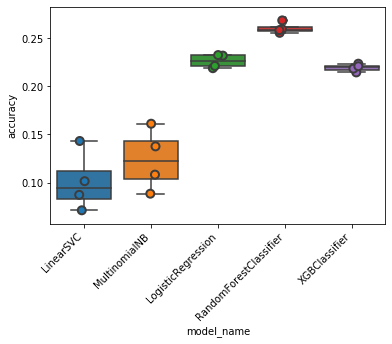

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
chart1 = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
chart2 = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [48]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.100801
LogisticRegression        0.226203
MultinomialNB             0.123899
RandomForestClassifier    0.260603
XGBClassifier             0.219402
Name: accuracy, dtype: float64